In [1]:
from sklearn import model_selection
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import calendar
import time

import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import cm, colors
from sklearn import preprocessing


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def read_data(init):
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [3]:
def format_df(df):
    df = df[df['lead_time_DAY'] == 0]
    df = df[df['lead_time_HOUR'] <= 18]
    error_months = (
            df.groupby([df.time.dt.month, "station"])[
                f"t2m_error"
            ]
            .mean()
        ).to_frame().reset_index()
    return error_months

In [4]:
def lasso(months_df, lulc, keys):
    lasso_df = pd.DataFrame(index=keys)
    for i in np.arange(1,13):
        df=months_df[months_df['time']==i]
        X = lulc
        y = df[['t2m_error']]
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)
        lasso_model = Lasso(alpha=0.3).fit(X_train,y_train)
        coefs_ls = lasso_model.coef_.tolist()
        df1 = pd.DataFrame(index=keys)
        df1[f'{i}'] = coefs_ls
        lasso_df = pd.concat([df1,lasso_df],axis=1)
    return lasso_df

In [5]:
def plot_heatmap(df):
    df = df.T
    fig, ax = plt.subplots(figsize=(12,9))
    ax.set_title(f'Lasso Regression Coefficients by Landtype')
    ax = sns.heatmap(df, vmin = -0.02, vmax = 0.02, cmap=cm.RdYlGn, annot = True)
    ax.set_ylabel('Month')
    ax.set_xlabel('Landtype')
    plt.tight_layout()

In [6]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [7]:
lulc = pd.read_csv('/home/aevans/nwp_bias/src/correlation/data/nlcd_gfs.csv')
lulc = lulc.drop(columns=['site', 'station'])
keys = lulc.keys()

# GFS

In [8]:
months_df = format_df(gfs_fcast_and_error_df)

In [9]:
lasso_df = lasso(months_df, lulc, keys)

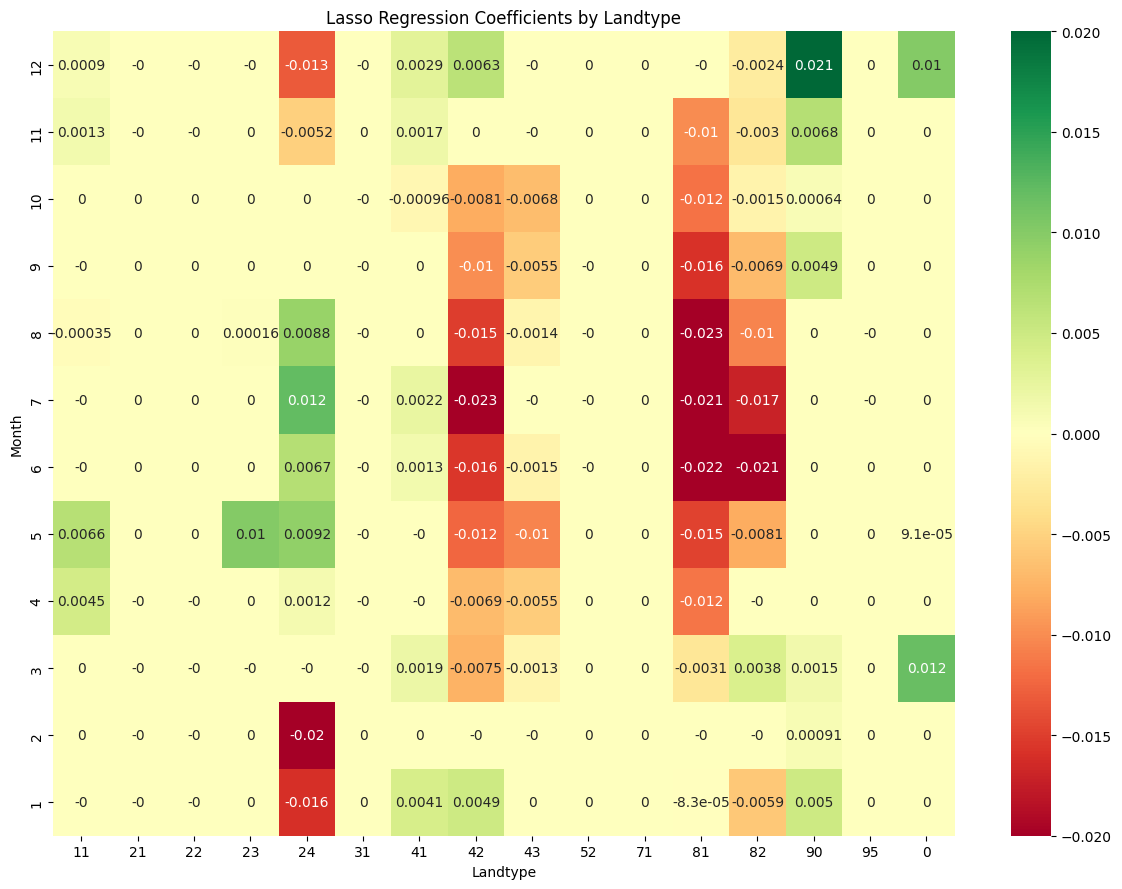

In [10]:
plot_heatmap(lasso_df)